# Bayesian Optimization: Uncertanity Quantification

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import pystorms
import GPyOpt
import baestorm
from pyswmm_lite import environment
import abc
from six import with_metaclass

class BOModel(with_metaclass(abc.ABCMeta, object)):
    """
    The abstract Model for Bayesian Optimization
    """
    
    MCMC_sampler = False
    analytical_gradient_prediction = False
    
    @abc.abstractmethod
    def updateModel(self, X_all, Y_all, X_new, Y_new):
        "Augment the dataset of the model"
        return
    
    @abc.abstractmethod
    def predict(self, X):
        "Get the predicted mean and std at X."
        return

    # We keep this one optional
    def predict_withGradients(self, X):
        "Get the gradients of the predicted mean and variance at X."
        return

    @abc.abstractmethod
    def get_fmin(self):
        "Get the minimum of the current model."
        return

In [18]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['lines.linewidth'] = 4.0
plt.rcParams['font.size'] = 18.0
plt.rcParams['font.sans-serif'] = 'Helvetica'

### Experiment setup

#### Network Topology
**Why this particular network?**
1. Numerical Calculation: This enables to compute all the possible configurations of control actions and numerically estimate the uncertanity, given a network and stormevent. 
2. Representation of Uncertanity: We cannot effectively convey uncertanity when we have more than 2 dimentions (in this case that is 2 basins). Figuring out how uncertanity works in larger dimension is still a challenging problem. 
3. Configuration: Why parallel ? why not series ?

#### Synthetic Inflows
Flows in a stormwater network has three fundamental components:
* How big is a rainevent? (amplitude)
* When will the peak be? (time)
* How wide is the dispersion? (spread)
    
This makes sense in the case of a single event. But how will perform in the case of multiple events. But we are using this validating our approach rather than saying these are things you have to do. Hence it might be ok to ignore the case with multiple stormevents.

In [4]:
def SynthNetwork(actions, flows):
    env = environment(baestorm.load_networks("parallel"), False)

    data = {}
    data["outflow"] = []
    data["overflow"] = []
    
    for time in range(0, len(flows)):
        # set the gate_position
        env._setValvePosition("1", actions[0])
        env._setValvePosition("1", actions[1])

        env.sim._model.setNodeInflow("P1", flows["P1"][time])
        env.sim._model.setNodeInflow("P2", flows["P2"][time])

        # record_data
        data["outflow"].append(env._getLinkFlow("1"))
        data["overflow"].append(env.sim._model.getNodeResult("P1", 4))

        # step through simulation
        _ = env.step()
    env._terminate()
    return data["outflow"], sum(data["overflow"])

In [5]:
def GaussianSignal(x, amplitude, timetopeak, dispersion):
    flows = amplitude * (1.0/(dispersion*(np.sqrt(2.0*np.pi)))) * np.exp(-0.5*((x-timetopeak)/dispersion)**2)
    return flows

In [6]:
x = np.linspace(-10.0, 10.0, 100)
flows = GaussianSignal(x, 1.0, -2.0, 2.0)

Text(0.5, 0, 'Duration of Signal')

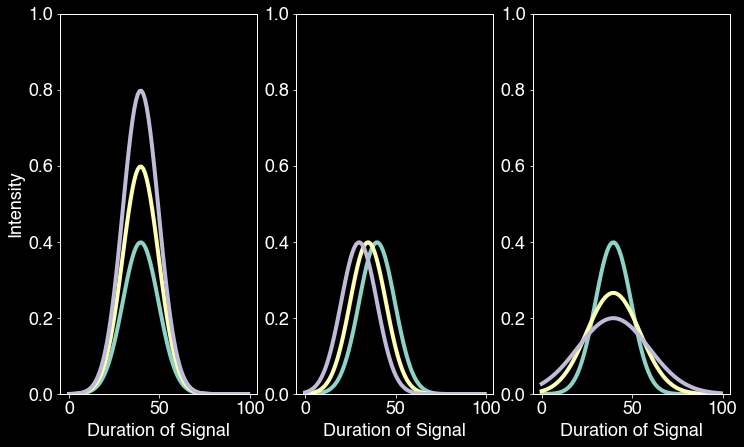

In [26]:
plt.subplot(1,3,1)
for amp in [2.0, 3.0, 4.0]:
    flows = GaussianSignal(x, amp, -2.0, 2.0)
    plt.plot(flows)
    plt.ylim([0.0, 1.0])
plt.ylabel("Intensity")
plt.xlabel("Duration of Signal")

plt.subplot(1,3,2)
for srt in [2.0, 3.0, 4.0]:
    flows = GaussianSignal(x, 2.0, -srt, 2.0)
    plt.plot(flows)
    plt.ylim([0.0, 1.0])
plt.xlabel("Duration of Signal")

plt.subplot(1,3,3)
for disp in [2.0, 3.0, 4.0]:
    flows = GaussianSignal(x, 2.0, -2.0, disp)
    plt.plot(flows)
    plt.ylim([0.0, 1.0])
plt.xlabel("Duration of Signal")

When we are working with only a single basin and one rainevent. Does it really matter, when the storm hits. No, because the given that we only have one event controller is going to look at the whole respose, time to peak does not matter. 

Hence, we should just focus on dispersion and amplitude.

# Single Basin: Amplitude

Before, we simulate 2 bains. Let us first start simulating one basin with just amplitude variance.

In [43]:
def SynthNetwork1(actions, flows):
    env = environment(baestorm.load_networks("parallel"), False)

    data = {}
    data["outflow"] = []
    data["overflow"] = []
    
    for time in range(0, len(flows)):
        # set the gate_position
        env._setValvePosition("1", actions)

        env.sim._model.setNodeInflow("P1", flows[time])
        env.sim._model.setNodeInflow("P2", 0.0)

        # record_data
        data["outflow"].append(env._getLinkFlow("1"))
        data["overflow"].append(env.sim._model.getNodeResult("P1", 4))

        # step through simulation
        _ = env.step()
    env._terminate()
    return data["outflow"], sum(data["overflow"])

In [44]:
amplitude = np.linspace(5.0, 20.0, 10)
padding_length = 500

flows_amp = lambda amp: np.pad(GaussianSignal(np.linspace(-10.0, 10.0, 100), amp , -2.0, 3.0), (0, padding_length), 'constant')

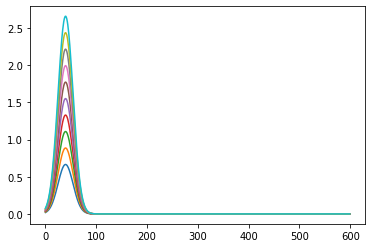

In [46]:
for i in amplitude:
    plt.plot(flows_amp(i))

Lets take a look at the response of these flows

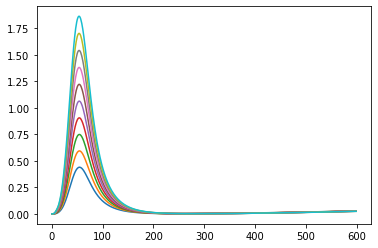

In [47]:
for i in amplitude:
    outflow, _ = SynthNetwork1(1.0, flows_amp(i))
    plt.plot(outflow)

# Single Basin: Dispersion

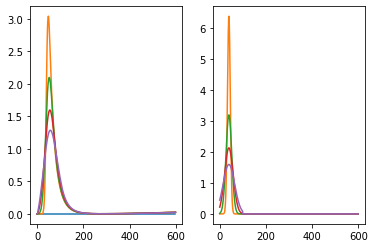

In [60]:
disper = np.linspace(0.0, 5.0, 5)
padding_length = 500

flows_disp = lambda disp: np.pad(GaussianSignal(np.linspace(-10.0, 10.0, 100), 20.0, -2.0, disp), (0, padding_length), 'constant')

for i in disper:
    outflow, _ = SynthNetwork1(1.0, flows_disp(i))
    plt.subplot(1,2,1)
    plt.plot(outflow)
    plt.subplot(1,2,2)
    plt.plot(flows_disp(i))

## What is noise and what you want to learn using GP?

I many not have to worry about which probability I am learning. As long as I can show that the results from the Gaussian Procees matches the emperical results.

In [65]:
class GPModel_Hetro(BOModel):
    """
    Class for handling hetroscodastic noise.

    :param kernel: GPy kernel to use in the GP model.
    :param noise_var: value of the noise variance if known.
    :param exact_feval: whether noiseless evaluations are available.
    :param optimizer: optimizer of the model. Check GPy for details.
    :param max_iters: maximum number of iterations used to optimize the parameters of the model.
    :param optimize_restarts: number of restarts in the optimization.
    :param sparse: whether to use a sparse GP (default, False). This is useful when many observations are available.
    :param num_inducing: number of inducing points if a sparse GP is used.
    :param verbose: print out the model messages (default, False).
    :param ARD: whether ARD is used in the kernel (default, False).

    .. Note:: This model does Maximum likelihood estimation of the hyper-parameters.

    """

    analytical_gradient_prediction = (
        True
    )  # --- Needed in all models to check is the gradients of acquisitions are computable.

    def __init__(
        self,
        kernel=None,
        noise_var=None,
        exact_feval=False,
        optimizer="bfgs",
        max_iters=1000,
        optimize_restarts=5,
        sparse=False,
        num_inducing=10,
        verbose=True,
        ARD=False,
    ):
        # Kernel has to incude hetroscodaticc gaussian noise 
        # could be included as sum. 
        self.kernel = kernel
        self.noise_var = noise_var
        self.exact_feval = exact_feval
        self.optimize_restarts = optimize_restarts
        self.optimizer = optimizer
        self.max_iters = max_iters
        self.verbose = verbose
        self.sparse = sparse
        self.num_inducing = num_inducing
        self.model = None
        self.ARD = ARD

    @staticmethod
    def fromConfig(config):
        return GPModel(**config)

    def _create_model(self, X, Y):
        """
        Creates the model given some input data X and Y.
        """

        # --- define kernel
        self.input_dim = X.shape[1]
        if self.kernel is None:
            kern = GPy.kern.Matern52(
                self.input_dim, variance=1.0, ARD=self.ARD
            )  # + GPy.kern.Bias(self.input_dim)
        else:
            kern = self.kernel

        # --- define model
        noise_var = Y.var() * 0.01 if self.noise_var is None else self.noise_var

        if not self.sparse:
            self.model = GPy.models.GPRegression(X, Y, kernel=kern, noise_var=noise_var)
        else:
            self.model = GPy.models.SparseGPRegression(
                X, Y, kernel=kern, num_inducing=self.num_inducing
            )

        # --- restrict variance if exact evaluations of the objective
        if self.exact_feval:
            self.model.Gaussian_noise.constrain_fixed(1e-6, warning=False)
        else:
            # --- We make sure we do not get ridiculously small residual noise variance
            self.model.Gaussian_noise.constrain_bounded(
                1e-9, 1e6, warning=False
            )  # constrain_positive(warning=False)

    def updateModel(self, X_all, Y_all, X_new, Y_new, samples=10, iterations=10, epsilon=0.01):
        """
        Updates the model with new observations.
        """
        if self.model is None:
            self._create_model(X_all, Y_all)
        else:
            self.model.set_XY(X_all, Y_all)

        # WARNING: Even if self.max_iters=0, the hyperparameters are bit modified...
        if self.max_iters > 0:
            # --- update the model maximizing the marginal likelihood.
            if self.optimize_restarts == 1:
                self.model.optimize(
                    optimizer=self.optimizer,
                    max_iters=self.max_iters,
                    messages=False,
                    ipython_notebook=False,
                )
            else:
                self.model.optimize_restarts(
                    num_restarts=self.optimize_restarts,
                    optimizer=self.optimizer,
                    max_iters=self.max_iters,
                    verbose=self.verbose,
                )
                
        # Create Kernels for 2 and 3 GP 
        # How does a multi-diemtional white noise kernel look?
        kernel2 = GPy.kern.RBF(input_dim=2) + GPy.kern.White(input_dim=2)
        kernel3 = GPy.kern.RBF(input_dim=2) + GPy.kern.WhiteHeteroscedastic(input_dim=2, num_data=X_all.shape[0])
        
        eps = np.inf
        count = 0
        while ~(eps <= epsilon or count > iterations):
            # Get the means and varainces for all the paramenters 
            m, v = self.model.predict(X_all)
            z = np.zeros(X.shape[0]) # This might bite me in the back 
            for j in range(0, z.shape[0]):
                var = 0.0
                for i in range(0, samples):
                    var += 0.5 * (Y_all[j] - np.random.normal(m[j], v[j]))**2
                z = var/samples
            z = np.log(z)

            # Step 2:
            gp2 = GPy.models.GPRegression(x.reshape(-1,1),z.reshape(-1,1),kernel2)
            gp2.optimize(messages=False)
            gp2.optimize_restarts(num_restarts = 5)
            m_n, v_n = gp2.predict(X_all)
            
            # Step-3:
            gp3 = GPy.models.GPRegression(x.reshape(-1,1),y.reshape(-1,1),kernel3)
            kernel3.parts[0].variance[0] = self.kernel.parts[0].variance[0]
            kernel3.parts[0].lengthscale[0] = self.kernel.parts[0].lengthscale[0]
            kernel3.parts[1].variance = np.exp(m_n).reshape(x.shape[0])

            m, v = gp3.predict(x.reshape(-1,1))
    
            diff = var_pref - v
            eps = np.dot(diff.T, diff)[0][0]
            gp1 = copy.deepcopy(gp3)
            var_pref = copy.deepcopy(v)
            count += 1         
            

    def _predict(self, X, full_cov, include_likelihood):
        if X.ndim == 1:
            X = X[None, :]
        m, v = self.model.predict(
            X, full_cov=full_cov, include_likelihood=include_likelihood
        )
        v = np.clip(v, 1e-10, np.inf)
        return m, v

    def predict(self, X, with_noise=True):
        """
        Predictions with the model. Returns posterior means and standard deviations at X. Note that this is different in GPy where the variances are given.

        Parameters:
            X (np.ndarray) - points to run the prediction for.
            with_noise (bool) - whether to add noise to the prediction. Default is True.
        """
        m, v = self._predict(X, False, with_noise)
        # We can take the square root because v is just a diagonal matrix of variances
        return m, np.sqrt(v)

    def predict_covariance(self, X, with_noise=True):
        """
        Predicts the covariance matric for points in X.

        Parameters:
            X (np.ndarray) - points to run the prediction for.
            with_noise (bool) - whether to add noise to the prediction. Default is True.
        """
        _, v = self._predict(X, True, with_noise)
        return v

    def get_fmin(self):
        """
        Returns the location where the posterior mean is takes its minimal value.
        """
        return self.model.predict(self.model.X)[0].min()

    def predict_withGradients(self, X):
        """
        Returns the mean, standard deviation, mean gradient and standard deviation gradient at X.
        """
        if X.ndim == 1:
            X = X[None, :]
        m, v = self.model.predict(X)
        v = np.clip(v, 1e-10, np.inf)
        dmdx, dvdx = self.model.predictive_gradients(X)
        dmdx = dmdx[:, :, 0]
        dsdx = dvdx / (2 * np.sqrt(v))

        return m, np.sqrt(v), dmdx, dsdx

    def copy(self):
        """
        Makes a safe copy of the model.
        """
        copied_model = GPModel(
            kernel=self.model.kern.copy(),
            noise_var=self.noise_var,
            exact_feval=self.exact_feval,
            optimizer=self.optimizer,
            max_iters=self.max_iters,
            optimize_restarts=self.optimize_restarts,
            verbose=self.verbose,
            ARD=self.ARD,
        )

        copied_model._create_model(self.model.X, self.model.Y)
        copied_model.updateModel(self.model.X, self.model.Y, None, None)
        return copied_model

    def get_model_parameters(self):
        """
        Returns a 2D numpy array with the parameters of the model
        """
        return np.atleast_2d(self.model[:])

    def get_model_parameters_names(self):
        """
        Returns a list with the names of the parameters of the model
        """
        return self.model.parameter_names_flat().tolist()

    def get_covariance_between_points(self, x1, x2):
        """
        Given the current posterior, computes the covariance between two sets of points.
        """
        return self.model.posterior_covariance_between_points(x1, x2)